# Lens modeling with lenstronomy

Author: Nahid,  Anowar Shajib \
Acknowledgement: Tanjela, Nushrat, Imtiaz.

# Import of standard python libraries

In [ ]:
!pip install lenstronomy

In [ ]:
import h5py
import joblib
import matplotlib.pyplot as plt
import numpy as np
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Workflow.fitting_sequence import FittingSequence

%matplotlib inline

## Load imaging data

In [ ]:
with h5py.File("/content/DESIJ1501+5208_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]

In [ ]:
with h5py.File("/content/psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]
kwargs_psf["psf_type"] = "PIXEL"

### Visualizing the data

<ipython-input-25-357dad159cb2>:2: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")


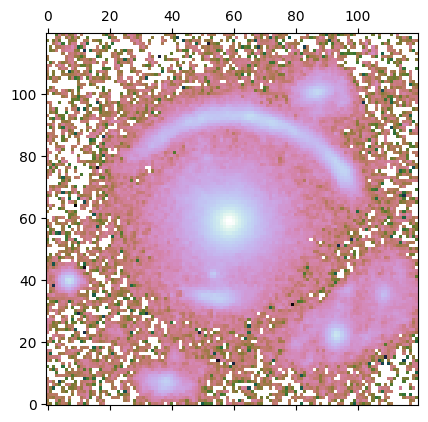

In [ ]:
image_data = kwargs_data["image_data"]
plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
plt.show()

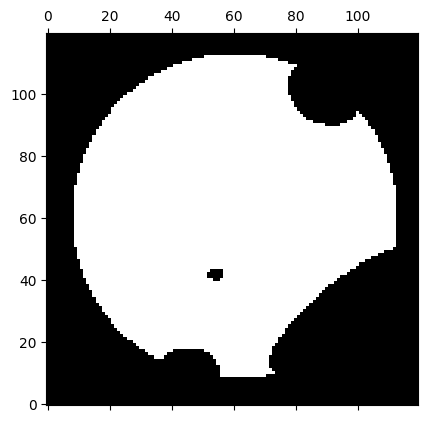

<ipython-input-26-d14db875bb19>:84: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
<ipython-input-26-d14db875bb19>:84: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")


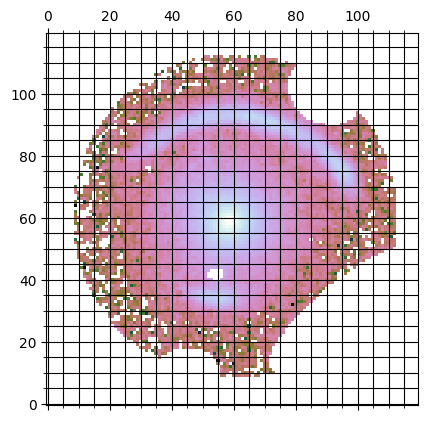

In [ ]:
ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r = 4.2  # arcseconds
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra,
    lens_center_dec,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords),
)


# for the galaxy at 1 o clock
mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.3,
    lens_center_dec + 3.2,
    1.0,
    0.8,
    np.pi / 0.85,
)


# for the galaxy at 5 o clock
mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.9,
    lens_center_dec - 2.4,
    2.5,
    0.76,
    np.pi / 0.56,
)


# for the galaxy at 7 o clock
mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1.2,
    lens_center_dec - 4.0,
    0.8,
    0.6,
    0,
)

# for the galaxy at center
mask_ext_4 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0.5,
    lens_center_dec - 1.5,
    0.2,
    0.15,
    0,
)

mask = (
    (1 - mask_outer)
    * (1 - mask_ext_1)
    * (1 - mask_ext_2)
    * (1 - mask_ext_3)
    * (1 - mask_ext_4)
)
mask[mask >= 1] = 1
mask[mask < 0] = 0
mask = mask.reshape(num_pix, num_pix)
plt.matshow(mask, origin="lower", cmap="cubehelix")
plt.show()

# applying the mask
masked_image_data = np.multiply(image_data, mask)
plt.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
plt.grid(which="both", color="black")
plt.minorticks_on()
plt.grid(which="minor", color="black")
plt.show()

## Building the lens model

In [ ]:
lens_model_list = ["EPL", "SHEAR"]
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

### Mass model of the lens galaxy

In [ ]:
# lens galaxy's mass model
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# setting EPL parameters
fixed_lens.append({})
kwargs_lens_init.append(
    {
        "theta_E": 1.5,
        "gamma": 2.0,
        "e1": 0.0,
        "e2": 0.0,
        "center_x": 0.0,
        "center_y": -0.0,
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.2,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 2.0,
        "gamma": 1.5,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 10.0,
        "gamma": 3.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)

# setting SHEAR Parameters
fixed_lens.append({"ra_0": 0, "dec_0": 0})
kwargs_lens_init.append({"gamma1": 0.1, "gamma2": 0.0, "ra_0": 0, "dec_0": 0})
kwargs_lens_sigma.append({"gamma1": 0.1, "gamma2": 0.1, "ra_0": 0, "dec_0": 0})
kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3, "ra_0": -100, "dec_0": -100})
kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3, "ra_0": 100, "dec_0": 100})

### Model of the source galaxy

In [ ]:
# source galaxy's light model
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

# setting SERSIC_ELLIPSE parameters
fixed_source.append({"n_sersic": 1.0})
kwargs_source_init.append(
    {
        "R_sersic": 0.05,
        "n_sersic": 1.0,
        "e1": 0.0,
        "e2": 0.0,
        "center_x": 0.0,
        "center_y": 0.0,
        "amp": 1,
    }
)
kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.2,
        "center_y": 0.2,
        "amp": 10,
    }
)
kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_source.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

# setting SHAPELETS parameters
fixed_source.append({"n_max": 8})
kwargs_source_init.append({"beta": 0.02, "center_x": 0.0, "center_y": 0.0})
kwargs_source_sigma.append({"beta": 0.001, "center_x": 0.2, "center_y": 0.2})
kwargs_lower_source.append({"beta": 0.001, "center_x": -10, "center_y": -10})
kwargs_upper_source.append({"beta": 0.08, "center_x": 10, "center_y": 10})

### Light model of the lens galaxy

In [ ]:
# lens galaxy's light model
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []


# 1st sersic
fixed_lens_light.append({"n_sersic": 1.0})

kwargs_lens_light_init.append(
    {
        "R_sersic": 0.5767,
        "n_sersic": 1.0,
        "e1": 0.0,
        "e2": 0.0,
        "center_x": 0.0,
        "center_y": 0.0,
        "amp": 1,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

# 2nd sersic
fixed_lens_light.append({"n_sersic": 4.0})
kwargs_lens_light_init.append(
    {
        "R_sersic": 0.5,
        "n_sersic": 2.0,
        "e1": 0.0,
        "e2": 0.0,
        "center_x": 0.0,
        "center_y": 0.0,
        "amp": 1,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

### Combining source and lens models

In [ ]:
joint_source_with_source = [[0, 1, ["center_x", "center_y"]]]
joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y"]]]

lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]

source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]


# combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_source_with_source": joint_source_with_source,
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
}

## Numerical Settings

In [ ]:
kwargs_likelihood = {"check_bounds": True, "image_likelihood_mask_list": [mask]}

kwargs_numerics = {"supersampling_factor": 1, "supersampling_convolution": False}

### Combining all the information to be sent to lenstronomy

In [ ]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band",
}

## Model fiting

In [ ]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

fitting_kwargs_list = [
    ["PSO", {"sigma_scale": 1.0, "n_particles": 200, "n_iterations": 200}]
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-0.88702728746618 reduced X^2 of best position
-3343.6493601037655 log likelihood
7539 effective number of data points
[{'theta_E': 2.642128153730113, 'gamma': 2.0893569659962306, 'e1': 0.10906888712179254, 'e2': 0.08797031077250934, 'center_x': 0.027288928476268102, 'center_y': -0.2156406701769868}, {'gamma1': 0.15500930071320249, 'gamma2': 0.06646630806870818, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.1301749123821264, 'n_sersic': 1.0, 'e1': -0.10918908049142839, 'e2': 0.007272677997059558, 'center_x': -0.11871599917633859, 'center_y': 0.30303220458856994}, {'amp': 1, 'n_max': 8, 'beta': 0.051576663849381546, 'center_x': -0.11871599917633859, 'center_y': 0.30303220458856994}] source result
[{'amp': 1, 'R_sersic': 0.43658244084370884, 'n_sersic': 1.0, 'e1': -0.033601121518607294, 'e2': -0.05171382264006122, 'center_x': 0.14667882579953004, '

### Save the best fit parameters

In [ ]:
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]
output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = "./DESIJ1501+5208_pso_output_r5.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

### Load the best fit parameters

In [ ]:
load_output_path = "/content//DESIJ1501+5208_pso_output_r5.joblib"
with open(load_output_path, "rb") as f:
    [input_, output_] = joblib.load(f)

(
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
) = input_

kwargs_result, multi_band_list_out, fit_output, _ = output_

##Visualizing the fitted model

-0.878866958705669 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.8788669587056831


<ipython-input-40-12d54f11901b>:22: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


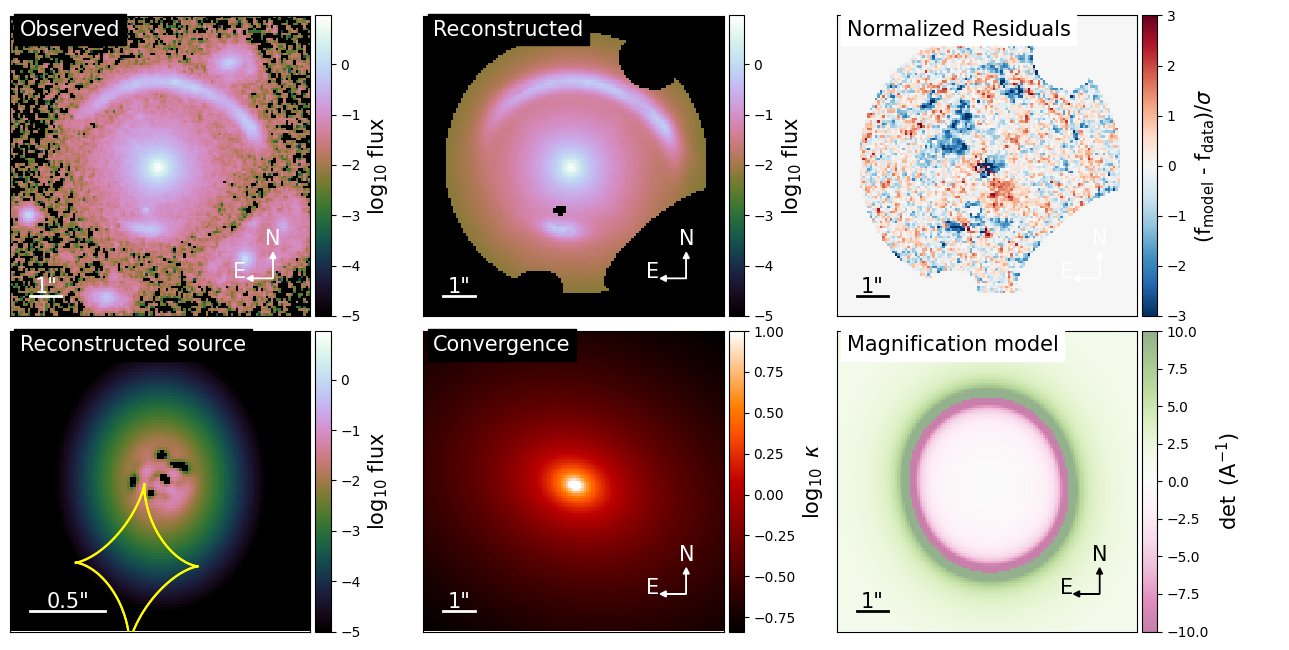

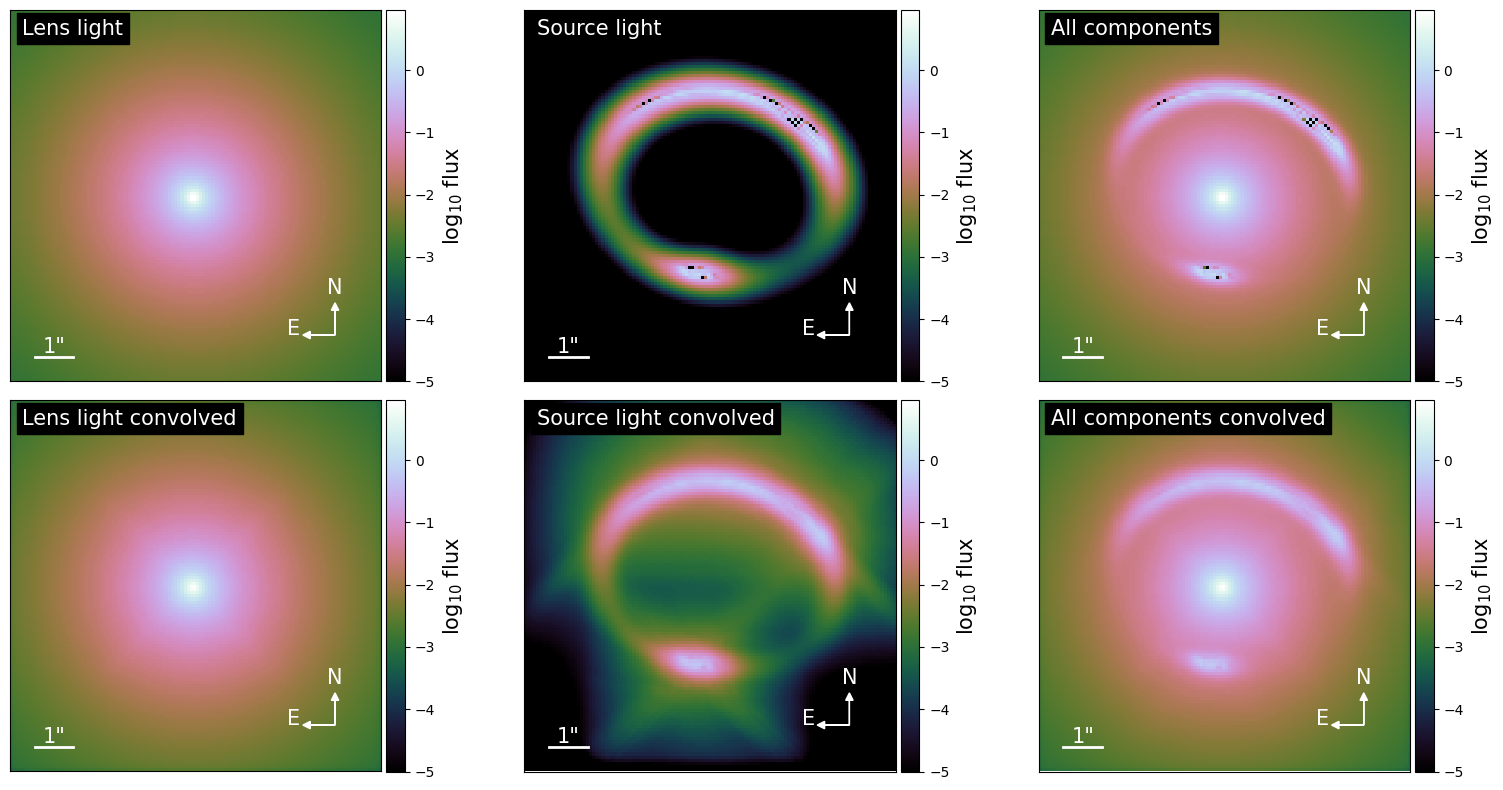

{'kwargs_lens': [{'theta_E': 2.642128153730113, 'gamma': 2.0893569659962306, 'e1': 0.10906888712179254, 'e2': 0.08797031077250934, 'center_x': 0.027288928476268102, 'center_y': -0.2156406701769868}, {'gamma1': 0.15500930071320249, 'gamma2': 0.06646630806870818, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 112.46427995058414, 'R_sersic': 0.1301749123821264, 'n_sersic': 1.0, 'e1': -0.10918908049142839, 'e2': 0.007272677997059558, 'center_x': -0.11871599917633859, 'center_y': 0.30303220458856994}, {'amp': array([-7.62873026e+02,  1.20915740e-01, -5.69385686e+01,  5.97526039e+01,
        1.00257183e+02, -9.45270888e+01, -3.99274798e+01,  1.48884593e+01,
       -7.65531851e+01, -2.10236197e+00, -1.98424529e+01,  5.51645422e+01,
       -5.39217671e+00,  1.07429441e+02, -1.41771042e+02,  1.79865580e+01,
       -8.78544791e+01,  1.21785170e+01, -8.85063236e+01,  3.62596267e+01,
       -1.14488536e+02, -7.47322014e+01,  7.30334124e-01,  1.52854313e+01,
        7.07582922e+01, -3.48437336e

In [40]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")


model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.02, with_caustics=True, scale_size=0.5, numPix=100
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result)